# A Digital Twin Approach to World Cup Modelling

Prever resultados de jogos é um passatempo, e ganha pão, de muitos nerds, sendo a Copa do Mundo o maior troféu. Você consegue achar predições usando uma [grande](http://previsaoesportiva.com.br/campeonatos/copa2018/boxplot.html) [variedade](http://www.chancedegol.com.br/copa18.htm) de [modelos](https://www.kaggle.com/agostontorok/soccer-world-cup-2018-winner/notebook) por aí, mas aqui vamos pensar em algo um pouco diferente. E se tivéssemos um Digital Twin de cada seleção?

[Um gêmeo digital é uma cópia digital de uma coisa física](https://en.wikipedia.org/wiki/Digital_twin). Como a cópia é digital, você pode usar ela para prever muitas coisas impraticáveis no mundo físico, como simular urubus entrando no digital twin de uma turbina de avião ou anteceder falhas em turbinas eólicas em locais inacessíveis.

É claro que definir esse bixo é muito mais fácil do que construir ele. Muita gente também vai se perguntar se isso não é a mesma coisa que as simulações da engenharia, ou machine learning e otimização. A resposta é: sim e não.

![Isso tem que ser falado](infelizmente.jpg)

Você forma um digital twin com um pouco de tudo isso aí. Um sistema de muitas partículas interagindo, como uma proteína, pode ser simulada através da descrição física de como cada um de seus vários atómos reage de acordo com variáveis do ambiente e interação com outros átomos. Em sistemas mais complicados, como pessoas conversando ou processos mais complexos, não temos o luxo de, partindo das leis da física, prever como uma pessoa vai agir. E daí entra o Machine Learning: aprendemos com o histórico como representar uma certa entidade e, depois, estamos livres para simular ela interagindo com o mundo e outras entidades.

No problema da Copa do Mundo temos duas possibilidades: podemos separar os dados de cada seleção e construir um modelo para cada, ou podemos fazer um grande preditor de resultado de jogos, olhando para todos os resultados de todos os jogos e, na hora do uso, alimentarmos essa máquina com somente os jogos de uma seleção para prever os seus resultados. A primeira abordagem é um pouco mais óbvia: jogos e dados do Brasil são usados para prever resultados do Brasil. Entretanto a segunda abordagem, mesmo que mais confusa, é mais rica: ela permite aproveitarmos todos os dados disponíveis e fazer previsões para o Brasil utilizando situações parecidas que ocorreram com outras seleções.

Em todo caso, é melhor avançarmos aos poucos. Na Seção 1 descrevo os dados que considerei na modelagem. Na Seção 2 faço um Digital Twin exclusivo com dados do Brasil e, na Seção 3, generalizo para construção de um Digital Twin de seleções.

# 1. Dados que eu peguei de outra pessoa

O usuário do Kaggle Agostonkorok já nos fez o grande favor de coletar os [principais dados](https://www.kaggle.com/agostontorok/soccer-world-cup-2018-winner/notebook) utilizados na previsão de jogos de seleções. Temos três conjuntos.

O primeiro é o ranking da Fifa, que contém a posição de cada país com uma precisão absurda (mensal):

In [39]:
import pandas as pd

ranking_fifa = pd.read_csv("Data/fifa_ranking.csv")
print(ranking_fifa.shape)
ranking_fifa

(57793, 16)


,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date
0,1,Germany,GER,0.00,57,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,1993-08-08
1,2,Italy,ITA,0.00,57,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,1993-08-08
2,3,Switzerland,SUI,0.00,50,9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,1993-08-08
3,4,Sweden,SWE,0.00,55,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,1993-08-08
4,5,Argentina,ARG,0.00,51,5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,CONMEBOL,1993-08-08
5,6,Republic of Ireland,IRL,0.00,54,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,1993-08-08
6,7,Russia,RUS,0.00,52,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,1993-08-08
7,8,Brazil,BRA,0.00,55,-5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,CONMEBOL,1993-08-08
8,9,Norway,NOR,0.00,49,5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,1993-08-08
9,10,Denmark,DEN,0.00,51,-1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,1993-08-08


Tab. 1. Ranking da Fifa. Tem informação aí desde 1993, melhor que muito dado público que se vê por aí. 

O segundo é uma mistura de dados históricos sobre as seleções da copa atual e informações sobre os jogos da primeira fase:

In [2]:
world_cup = pd.read_csv("Data/World Cup 2018 Dataset.csv")
print(world_cup.shape)
world_cup.head(5)

(33, 20)


,Team,Group,Previous appearances,Previous titles,Previous finals,Previous semifinals,Current FIFA rank,First match against,Match index,history with first opponent W-L,history with first opponent goals,Second match against,Match index.1,history with second opponent W-L,history with second opponent goals,Third match against,Match index.2,history with third opponent W-L,history with third opponent goals,Unnamed: 19
0,Russia,A,10.0,0.0,0.0,1.0,65.0,Saudi Arabia,1.0,-1.0,-2.0,Egypt,17.0,NaN,NaN,Uruguay,33.0,0.0,0.0,NaN
1,Saudi Arabia,A,4.0,0.0,0.0,0.0,63.0,Russia,1.0,1.0,2.0,Uruguay,18.0,1.0,1.0,Egypt,34.0,-5.0,-5.0,NaN
2,Egypt,A,2.0,0.0,0.0,0.0,31.0,Uruguay,2.0,-1.0,-2.0,Russia,17.0,NaN,NaN,Saudi Arabia,34.0,5.0,5.0,NaN
3,Uruguay,A,12.0,2.0,2.0,5.0,21.0,Egypt,2.0,1.0,2.0,Saudi Arabia,18.0,-1.0,-1.0,Russia,33.0,0.0,0.0,NaN
4,Porugal,B,6.0,0.0,0.0,2.0,3.0,Spain,3.0,-12.0,-31.0,Morocco,19.0,-1.0,-2.0,Iran,35.0,2.0,5.0,NaN


Tab. 2: Resumo sobre as seleções da copa. Mas que excelente ideia colocar informações passadas e futuras na mesma tabela.

Por último, e mais importante, um resumo do resultado de todos os jogos entre seleções da história

In [3]:
game_result = pd.read_csv("Data/results.csv")
print(game_result.shape)
game_result.head(5)

(39045, 9)


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


Tab. 3. Todos os jogos da história. Nessa tabela o Palmeiras também não tem mundial.

Nossos dados contém dois tipos de informação. As tabelas ranking_fifa e world_cup contém dados sobre o perfil da seleção, enquanto a tabela game_result contém uma espécie de linha do tempo de uma seleção. Essa distinção será muito importante para um Digital Twin, já que o queremos prever é uma continuação dessa linha do tempo.

# 2. Digital Twin do Brasil

Vamos filtrar os dados para considerar somente os jogos do Brasil no histórico. Vou desconsiderar informações de mandante de campo porque é difícil considerar isso em uma copa do mundo.

In [38]:
game_result_brasil_home = game_result[game_result['home_team'] == 'Brazil']
print(game_result_brasil_home.shape)

game_result_brasil_away = game_result[game_result['away_team'] == 'Brazil']
print(game_result_brasil_away.shape)

def vconcat_home_away_results(away_df,home_df):    
    
    results = pd.concat([away_df.rename(columns={'home_team' : 'team2','away_team':'team1',
                    'home_score': 'team2_score','away_score':'team1_score'}),\
                         home_df.rename(columns={'home_team' : 'team1','away_team':'team2',
                    'home_score': 'team1_score','away_score':'team2_score'})],sort=True)
    
    results['AAAA-MM'] = results['date'].str[:7]
    
    return results.drop(['tournament','city','country','neutral'],axis=1)

game_results_brasil = vconcat_home_away_results(game_result_brasil_away,game_result_brasil_home)
print(game_results_brasil.shape)
game_results_brasil.head(5)

(548, 9)
(403, 9)
(951, 6)


,date,team1,team1_score,team2,team2_score,AAAA-MM
398,1914-09-20,Brazil,0,Argentina,3,1914-09
399,1914-09-27,Brazil,1,Argentina,0,1914-09
424,1916-07-10,Brazil,1,Argentina,1,1916-07
429,1916-07-18,Brazil,1,Uruguay,0,1916-07
454,1917-10-03,Brazil,2,Argentina,4,1917-10


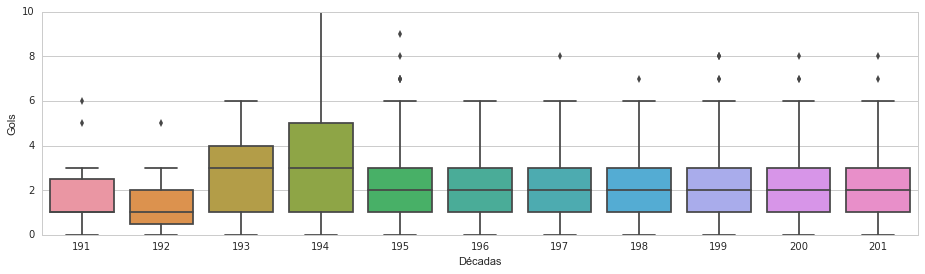

In [57]:
%matplotlib inline
import seaborn as sns

sns.set(rc={'figure.figsize':(15.7,4)})
sns.set_style("whitegrid")

ax = sns.boxplot(y=game_results_brasil['team1_score'], 
                 x=game_results_brasil['AAAA-MM'].str[:3])
ax.set_xlabel('Décadas')
ax.set_ylabel('Gols')

Tab. 4. Gols do Brasil ao longo das décadas. As coisas foram animadas mesmo nos anos 40.

Preciso de informações do ranking do Brasil (team1) e do adversário (team2) no momento do jogo. Essas são as informações de "perfil" dos nossos times, enquanto os jogos representam a linha do tempo da seleção.

Filtrar com a tabela de rankings da Fifa também ajuda a manter somente informações de jogos mais recentes.

In [91]:
ranking_fifa['AAAA-MM'] = ranking_fifa['rank_date'].str[:7]

game_results_rkteam1 = pd.merge(game_results_brasil, ranking_fifa.drop('country_abrv',axis=1),
                        left_on=['team1','AAAA-MM'],
                        right_on = ['country_full','AAAA-MM'],
                        how='inner',
                       )

game_results_rk_brasil = pd.merge(game_results_rkteam1, ranking_fifa.drop('country_abrv',axis=1),
                        left_on=['team2','AAAA-MM'],
                        right_on = ['country_full','AAAA-MM'],
                        how='inner',
                        suffixes=('','_team2')
                       )

game_results_rk_brasil.shape

(342, 36)

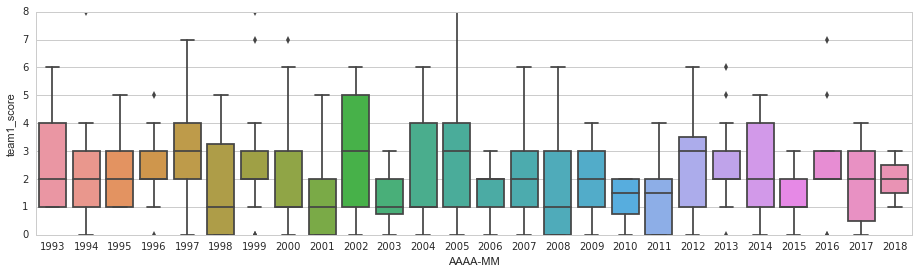

In [74]:
ax = sns.boxplot(y=game_results_rk_brasil['team1_score'], 
                 x=game_results_rk_brasil['AAAA-MM'].str[:4])

Com a tabela game_results_rk_brasil podemos começar a modelar. Aqui team1 representa o Brasil e team2 o adversário. Como temos poucos jogos, vamos tentar prever somente se houve vitória, derrota ou empate do Brasil.

In [114]:
game_results_rk_brasil['TARGET'] = game_results_rk_brasil.apply(lambda row : 'WIN' if row['team1_score'] > row['team2_score']
                                                             else 'LOS' if row['team2_score'] > row['team1_score']
                                                             else 'DRW',axis=1)
game_results_rk_brasil[['team1_score','team2_score','TARGET']].head(5)

,team1_score,team2_score,TARGET
0,5,1,WIN
1,1,1,DRW
2,1,1,DRW
3,2,0,WIN
4,6,0,WIN


Essas são as colunas úteis para modelarmos:

In [110]:
variables = ['rank', 'total_points', 'previous_points', 'rank_change', 'cur_year_avg', 'cur_year_avg_weighted', 'last_year_avg',
'last_year_avg_weighted', 'two_year_ago_avg', 'two_year_ago_weighted', 'three_year_ago_avg', 'three_year_ago_weighted'] +\
['rank_team2', 'country_full_team2', 'total_points_team2', 'previous_points_team2', 'rank_change_team2', 'cur_year_avg_team2',
'cur_year_avg_weighted_team2', 'last_year_avg_team2','last_year_avg_weighted_team2', 'two_year_ago_avg_team2','two_year_ago_weighted_team2', 'three_year_ago_avg_team2',
'three_year_ago_weighted_team2']


Como o futebol é uma caixinha de surpresas, vou separar 10% da amostra para teste, enquanto o restante vou escolher os principais parâmetros por grid-search-cross-validation de 5-folds:

In [118]:
from sklearn.model_selection import train_test_split

X_train, X_test,y_train,y_test = train_test_split(game_results_rk_brasil[variables], game_results_rk_brasil['TARGET'],
                                                  test_size=0.1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(307, 25)
(35, 25)
(307,)
(35,)
